<a href="https://colab.research.google.com/github/1PedroGabriel/1PedroGabriel/blob/main/Image_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Código Baseado no trabalho de Bertalmio et al

import numpy as np

In [ ]:

def curvature(I):
    Iy, Ix = np.gradient(I)
    Iyy, _ = np.gradient(Iy)
    _, Ixx = np.gradient(Ix)
    Ixy = np.gradient(Ix, axis=0)
    num = Ixx * Iy**2 - 2 * Ix * Iy * Ixy + Iyy * Ix**2


    denom = (Ix**2 + Iy**2 + 1e-10)**1.5

    return num / denom

def anisotropic_curvature_diffusion_indexed(I, g_epsilon, coords, n_iter=30, dt=0.1):
    I = I.copy()
    for _ in range(n_iter):
        Iy, Ix = np.gradient(I)
        grad_mag = np.sqrt(Ix**2 + Iy**2 + 1e-10)
        kappa = curvature(I)
        dI = g_epsilon * kappa * grad_mag
        for y, x in coords:
            I[y, x] += dt * dI[y, x]
    return I


In [ ]:
### Funções auxiliares

# derivada em x para frente

def forward_diff_x(matrix, i, j):
  return matrix[i + 1][j] - matrix[i][j]

# derivada em x para trás
def backward_diff_x(matrix, i, j):
  return matrix[i][j] - matrix[i - 1][j]

# derivada em y para frente
def forward_diff_y(matrix, i, j):
  return matrix[i][j + 1] - matrix[i][j]

# derivada em y para trás
def backward_diff_y(matrix, i, j):
  return matrix[i][j] - matrix[i][j - 1]

# derivada segunda central em x
def central_2diff_x(matrix, i, j):
  return (matrix[i + 1][j] - 2 * matrix[i][j] + matrix[i - 1][j])

# derivada segunda central em y
def central_2diff_y(matrix, i, j):
  return (matrix[i][j + 1] - 2 * matrix[i][j] + matrix[i][j - 1])

# operador laplaciano
def laplacian(matrix, i, j):
  return central_2diff_x(matrix, i, j) + central_2diff_y(matrix, i, j)

def delta_L(matrix, i, j):
  return np.array([laplacian(matrix, i+1, j) - laplacian(matrix, i-1, j), laplacian(matrix, i, j+1) - laplacian(matrix, i, j-1)])

# vetor normal ao gradiente
def vector_N(matrix, i, j):
  return np.array([-forward_diff_y(matrix, i, j), forward_diff_x(matrix, i, j)])

def beta(matrix, i, j):
  if(np.linalg.norm(vector_N(matrix, i, j)) == 0):
    return 0

  return np.dot(delta_L(matrix, i, j), vector_N(matrix, i, j)) / np.linalg.norm(vector_N(matrix, i, j))

# Calcula a norma do vetor gradiente do pixel (i,j)
def gradient_norm(matrix, i, j):

  beta_value = beta(matrix, i, j)

  if(beta_value > 0):

    return np.sqrt( np.min([0, backward_diff_x(matrix, i, j)]) ** 2 + np.max([0, forward_diff_x(matrix, i, j)]) ** 2 + np.min([0, backward_diff_y(matrix, i, j)]) ** 2 + np.max([0, forward_diff_y(matrix, i, j)]) ** 2 )

  if(beta_value < 0):

    return np.sqrt( np.max([0, backward_diff_x(matrix, i, j)]) ** 2 + np.min([0, forward_diff_x(matrix, i, j)]) ** 2 + np.max([0, backward_diff_y(matrix, i, j)]) ** 2 + np.min([0, forward_diff_y(matrix, i, j)]) ** 2 )
  return 0

def Inpainting(old_matrix, mascara, iter, A, B, epslon ):

  matrix = old_matrix
  for i in range(iter):

    for _ in range(A):
      for pixels in mascara:

        smooth = laplacian(matrix, pixels[0], pixels[1])
        isophote_dir = vector_N(matrix, pixels[0], pixels[1])
        beta_n = beta(matrix, pixels[0], pixels[1])
        grad_norm = gradient_norm(matrix, pixels[0], pixels[1])
        update = beta_n * grad_norm
        matrix[pixels[0]][pixels[1]] += epslon * update

    for _2 in range(B):
      matrix = anisotropic_curvature_diffusion_indexed(matrix, 0.1, mascara, 30, 0.1)
  return matrix

  # A mascara deve ser um array contendo os pontos




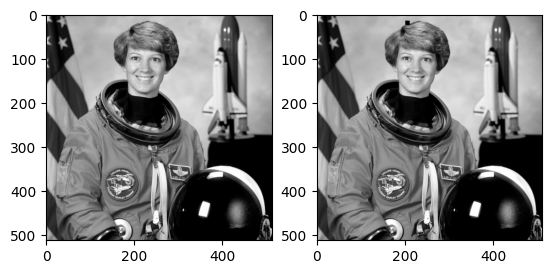

In [ ]:
from skimage import data
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize


image = np.array(Image.fromarray(data.astronaut()).convert("L"))


image = image.astype(dtype=np.float32)
image /= image.max().astype(dtype=np.float32)


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image, cmap="gray")

# Mascara
start_row = 14
start_col = 199
size = 12 # Define the size of the square

mask = []

for i in range(start_row, start_row + size):
    for j in range(start_col, start_col + size):
        mask.append([i, j])


# Dano
start_row = 15
start_col = 200
size = 10 # Define the size of the square

damage = []

for i in range(start_row, start_row + size):
    for j in range(start_col, start_col + size):
        damage.append([i, j])


for dm_points in damage:
  image[dm_points[0]][dm_points[1]] = 0


ax2.imshow(image, cmap="gray")



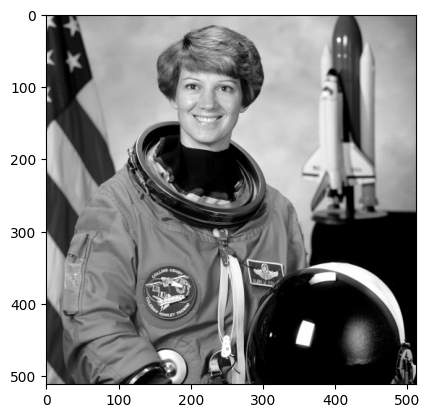

In [ ]:

plt.imshow(Inpainting(image, mask, 200, 15, 2, 0.1), cmap="gray")

In [ ]:
image.shape